# Hometask on SECD interview

## Done by Alexander Taschyan

The point of this notebook is to perform basic pricing of some exotic path-dependent options, with some examples. All data was found on BBG, but the add-on was not used. 

Please pay attention, that in this notebook only pricing engine is realised, without any greeks computations.

Before running it by your own, please be sure that all libraries are installed.

## 0. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## 1. Processing Input Data on Volatility Surface for GE stock

### 1.1 Read Pandas DF

In [2]:
df = pd.read_excel("GE1.xlsx", sheet_name=0)
df1 = df.melt(id_vars=['Date'])
df1.head(5)

,Date,variable,value
0,0.002740,80,0.4333
1,0.021918,80,0.4333
2,0.041096,80,0.4289
3,0.060274,80,0.3981
4,0.079452,80,0.3772


### 1.2 Plotting The Surface (using 2nd degree polynomial fitted surface)

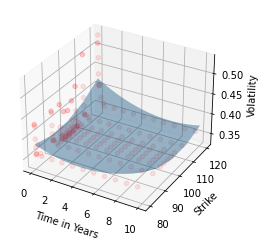

In [3]:
X,Y = np.meshgrid(np.linspace(0, 10, 1000), np.linspace(80, 120, 5)) #Surface fitted values X, Y
XX = X.flatten()
YY = Y.flatten()
data = np.array(df1.values.tolist()) #Unpack Data
A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2]) #Using OLS regression to fit the 3D array to obtain continous surface
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

#Plot the 3D chart for Surface

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.5)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', alpha = 0.1)
plt.xlabel('Time in Years')
plt.ylabel('Strike')
ax.set_zlabel('Volatility')
ax.axis('auto')
plt.show()

## 2. Models

### 2.1 Assumptions
1. Settled today.
2. Risk free rate is determined by CIR model (are stochastic)
3. $W^r$ and $W^S$ are independent

For the purpose of simplicity I decided to use LV model with stochastic interest rates for the options. 
It is not the most common choice of modelling such dependencies as Equity prces are better approximated by Jump diffusion models (Mark Joshi, Ch 14). 

CIR process was chosen as the rates on the US market are mostly positive, so there is no need to use normal model, as Vasichek or HW. We have no need to use term structure models like HJM model, as we need the instant rate for now.

Moreover, for the simplicity it was decided to use constant volatility for rates, which can be calibrated to Cap and Swaption prices on the market.

### 2.2 Simulating GBM path

In [4]:
def rand_GBM_approximate1(S0, r0, divy, theta, k, sigma_r, K, T, df, N=1000): #Declare function
    time_grid = np.linspace(0, T, N+1)  # Making a grid for the time (to get equal dt)
    S_t = np.full(N+1, np.nan) #Matrix for storing prices at each time interval
    r = np.full(N+1, np.nan) #Matrix for storing stochastic interest rate at each time interval
    sigma = np.full(N+1, np.nan) #Matrix for storing local volatility at each time interval
    
    #Fitting the surface for volatility
    X,Y = np.meshgrid(np.linspace(0, 10, 1000), np.linspace(80, 120, 5))  #Surface fitted values X, Y
    XX = X.flatten()
    YY = Y.flatten()
    data = np.array(df.values.tolist()) #Unpack Data
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2]) #Using OLS regression to fit the 3D array to obtain continous surface
    
    #Boundary conditions
    S_t[0] = S0 #For Price
    r[0] = r0 #For interest rates
    
    for i in range(N):
        dt = time_grid[i+1] - time_grid[i] #Change in time
        
        sigma[i] = C[0] + time_grid[i] * C[1] + K * C[2] + time_grid[i] * K * C[3] \
        + time_grid[i] * time_grid[i] * C[4] + K * K * C[5]  #Finding interpolated volatility
        
        dW_t = np.sqrt(dt) * np.random.normal() #Simulating Brownian Motion for Stock
        dw_r = np.sqrt(dt) * np.random.normal() #Simulating Brownian Motion for Interest rate
        
        S_t[i + 1] = S_t[i] + (r[i] - divy) * S_t[i] * dt + sigma[i] * S_t[i] * dW_t #GBM PDE equation
        r[i+1] = r[i] + k * (theta - r[i]) * dt + sigma_r * np.sqrt(r[i]) * dw_r #CIR PDE Equation
    
    return S_t, r, time_grid 

## 3. Pricings

### 3.1 Pricing Vanilla European Option

European vanilla call is a contingent claim paying the holder a $max(S, 0)$, where S is the reference asset price.

The most common approach of computing European option price is to use BS formula, but it has several major drawbacks, like constant volatility, so it is more of framework.

Here the MC approach is presented. 

Please be assured, that no variance reduction techniques were introducted here.

In general, we ca reduce variance using the price obtained by BS model, as a control variables.

In [5]:
def price_european_option_by_MC(S0, K, divy, T, sigma, k, theta, sigma_r, r0, N_sample,
                                N_time_steps, Type_option, df): #European Call price
 
    V = np.full(N_sample, np.nan) #Matrix for Payoffs 

    for i in range(N_sample): #MC simulation
        
        S, r, t = rand_GBM_approximate1(
            S0=S0, #Initial Price
            K = K, #Strike as moneyness
            r0 = r0, #Initial Interest Rate
            divy = divy, #Dividend yield
            k = k, #Scaling for CIR
            theta = theta, #Mean reverting
            sigma_r = sigma_r, #Volatility of Interest Rate
            T=T, #Time to expiration
            df = df, #Dataset
            N=N_time_steps #Number of time intervals
        )
        
        S_T = S[-1] #Last price
        
        discount = 1/(np.exp(np.trapz(r, t))) #Discount Factor
        
        if Type_option == 'Call':
            V[i] = np.maximum(0, S_T - K * S0 / 100) * discount #Call payoff
            
        elif Type_option == 'Put':
            V[i] = np.maximum(0, K * S0 / 100 - S_T) * discount #Put payoff
            
        else:
            return('Invalid Type')
        
    return np.mean(V) #Mean Payoff is the price

In [6]:
params = {
    'S0'          : 14.25, #initial price
    'r0'          : 0.005, #rfr
    'divy'        : 0.0002, #dividend yield
    'k'           : 1, #scaling
    'theta'       : 0.01, #mean reversion
    'K'           : 92, #Strike Price in % of S0
    'T'           : 1, #Maturity time in years
    'sigma'       : 0.1, #Annualized volatility
    'sigma_r'     : 0.0005, #IR vol
    'Type_option' :'Call' #Option type Put/Call
}
price_european_option_by_MC(**params, N_sample=1000, N_time_steps=100, df = df1)

2.6392967082937404

### 3.2 Pricing Digital Option

Here the goal is to price a standard digital option by Monte-Carlo. 

There are several ways to approximate the price of the binary option, and one common is to use replication by call spread. The value of such replication can be a control variable for the variance reduction purposes.

In [7]:
def price_digital_by_MC(S0, K, divy, DP, T, k, theta, sigma_r, r0, N_sample, N_time_steps, Type_option, df):
    
    V = np.full(N_sample, np.nan)
    for i in range(N_sample):
        
        S, r, t = rand_GBM_approximate1(
            S0=S0, #Initial Price
            K = K, #Strike as moneyness
            r0 = r0, #Initial Interest Rate
            divy = divy, #Dividend yield
            k = k, #Scaling for CIR
            theta = theta, #Mean reverting
            sigma_r = sigma_r, #Volatility of Interest Rate
            T=T, #Time to expiration
            df = df, #Dataset
            N=N_time_steps #Number of time intervals
        )
     
        S_T = S[-1] #Last price
        
        discount = 1/(np.exp(np.trapz(r, t))) #Discount Factor
        
        if Type_option == 'Call':
            V[i] = np.sign(np.maximum(S_T - K * S0 / 100, 0)) * DP * discount #Call payoff: DP if S_T > K

        elif Type_option == 'Put':
            V[i] = np.sign(np.maximum(K * S0 / 100 - S_T, 0)) * DP * discount #Put payoff: DP if S_T < K

        else:
            return('Invalid type')
            
        
    return np.mean(V) #Mean Payoff is the price

In [8]:
params = {
    'S0'          : 50, #initial price
    'DP'          : 1, #Digital payment
    'r0'          : 0.005, #rfr
    'divy'        : 0.0002, #dividend yield
    'k'           : 1, #scaling
    'theta'       : 0.01, #mean reversion
    'K'           : 80, #Strike Price
    'T'           : 1, #Maturity time in years
    'sigma_r'     : 0.0005, #IR vol
    'Type_option' : 'Call' #Option type Put/Call
}
price_digital_by_MC(**params, N_sample=1000, N_time_steps=100, df = df1)

0.6624497883241466

### 3.3 Pricing Digital Option with Memory and Voluntary Autocallable Feature 

Here is some kind of the structured product, where memory feature is the accumulating coupon feature even if there is no strike exceeding, and autocallable feature means that if option finishes below or above the bareer level, then it ceases and pays all accumulated coupons.

In [9]:
def find_non_zero(lst): #Supporting function to find first non-zero element in the array (for autocall code)
    for num in lst:
        if num != 0:
            return num

In [10]:
def price_digital_memory_by_MC(S0, K, divy, DP, T, k, theta, sigma_r, r0, N_sample, N_times, 
                               N_settles, Type_option, Autacall, df):
    
    V = np.full(N_sample, np.nan) #Matrix for Payoffs 
    V_matrix = np.full((N_sample, N_settles), np.nan) #Matrix for each digital
    
   
    
    for i in range(N_sample): #MC simulation
        
        S, r, t = rand_GBM_approximate1(
            S0=S0, #Initial Price
            K = K, #Strike as moneyness
            r0 = r0, #Initial Interest Rate
            divy = divy, #Dividend yield
            k = k, #Scaling for CIR
            theta = theta, #Mean reverting
            sigma_r = sigma_r, #Volatility of Interest Rate
            T=T, #Time to expiration
            df = df, #Dataset
            N=N_times #Number of time intervals
        )
        
        
        S_matrix = np.full(N_settles, np.nan) #For each digital option
        discount_matrix = np.full(N_settles, np.nan) #For each digital as they have different maturities
        
        for j in range (N_settles):
            S_matrix[j] = S[int(np.round(N_times * (j + 1) / N_settles))] #Slicing GBM prices for each digital
            discount_matrix[j] = 1/(np.exp(np.trapz(r[:int(np.round(N_times * (j + 1) / N_settles))], 
                                                t[:int(np.round(N_times * (j + 1) / N_settles))]))) #Slicing DFs for each digital
            if Type_option == 'Call':
                V_matrix[i][j] = np.sign(np.maximum(S_matrix[j] - K * S0 / 100, 0)) * (j+1) * DP * discount_matrix[j] #Call
            
            elif Type_option == 'Put':
                V_matrix[i][j] = np.sign(np.maximum(K * S0 / 100 - S_matrix[j], 0)) * (j+1) * DP * discount_matrix[j] #Put
            
            else:
                return('Invalid type')
        
        if Autacall == True: #Autocallable feature code
            V[i] = find_non_zero(V_matrix[i]) #Find first time the price broke the ATM Barrier on the settlement date
            V = np.where(np.isnan(V), 0, V) #Replace NaN
        else: #If it is not Autocall
            Support_list = np.zeros(N_sample) #Support list for calculating payoffs
            Payoffs_no_ac = np.full((N_sample, N_settles), np.nan) #Payoff matrix
            np.transpose(Payoffs_no_ac)[0] = np.transpose(V_matrix)[0] #Initial Conditions
            for k in range (1, N_settles): 
                Support_list += np.transpose(Payoffs_no_ac)[k-1] #Summation
                np.transpose(Payoffs_no_ac)[k] = np.maximum(np.transpose(V_matrix)[k] - Support_list, 0) #Calc
            V[i] = np.sum(Payoffs_no_ac[i]) #Result
            
    return np.mean(V)

In [12]:
params = {
    'S0'        : 50, #initial price
    'DP'        : 1, #Digital payment 1
    'N_settles' : 7, #Number of coupon periods
    'r0'        : 0.005, #rfr
    'divy'      : 0.0002, #dividend yield
    'k'         : 1, #scaling
    'theta'     : 0.01, #mean reversion
    'K'         : 80, #Strike Price
    'T'         : 1, #Maturity time in years
    'sigma_r'   : 0.0005, #IR vol
}
price_digital_memory_by_MC(**params, Type_option = 'Call', N_sample=1000, N_times=100, Autacall = False, df = df1)

5.677386385683265

# Thank You for Reviewing

## I am glad to receive any comments on the code.

E-mail: a.taschian@gmail.com

Mob UK: +44-7467-796532

Mob Rus: +7-919-999-86-48